In [1]:
import sys
sys.path.append("..")

In [2]:
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
import pyro.distributions as dist

import tyxe


import numpy as np
import copy

In [3]:
pyro.set_rng_seed(42)

In [4]:
x1 = torch.rand(50, 1) * 0.3 - 1
x2 = torch.rand(50, 1) * 0.5 + 0.5
x = torch.cat([x1, x2])
y = x.mul(4).add(0.8).cos() + 0.1 * torch.randn_like(x)

x_test = torch.linspace(-2, 2, 401).unsqueeze(-1)
y_test = x_test.mul(4).add(0.8).cos()

In [5]:
dataset = data.TensorDataset(x, y)
loader = data.DataLoader(dataset, batch_size=len(x))

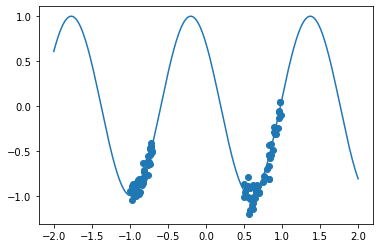

In [6]:
plt.scatter(x.squeeze(), y)
plt.plot(x_test.squeeze(), y_test)

In [7]:
net = nn.Sequential(nn.Linear(1, 50), nn.Tanh(), nn.Linear(50, 1))
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x), scale=0.1)
guide = partial(tyxe.guides.AutoNormal, init_scale=0.01)
bnn0 = tyxe.VariationalBNN(net, prior, obs_model, guide)

## Global train

In [8]:
bnn = copy.deepcopy(bnn0)

In [31]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-3})
elbos = []
def callback(bnn, i, e):
    elbos.append(e)
    
with tyxe.poutine.local_reparameterization():
    bnn.fit(loader, optim, 10000, callback)

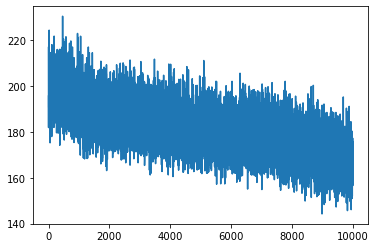

In [32]:
plt.plot(elbos)

In [33]:
m, sd = bnn.predict(x_test, num_predictions=32)

(-2.0, 2.0)

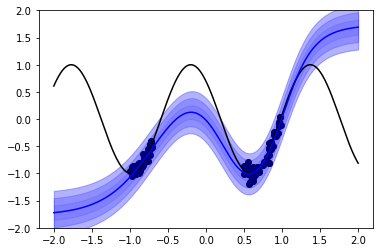

In [34]:
plt.scatter(x, y, color="black")
plt.plot(x_test, y_test, color="black")
plt.plot(x_test, m.detach(), color="blue")
for c in range(1, 4):
    plt.fill_between(x_test.squeeze(), (m - c * sd).squeeze(), (m + c * sd).squeeze(), alpha=c * 0.1, color="blue")
plt.ylim(-2, 2)

In [35]:
torch.square(m-y_test).sum()/len(y_test)

tensor(1.4098)

In [14]:
with tyxe.poutine.local_reparameterization():
    m, sd = bnn.predict(x_test, num_predictions=32)

torch.save((x, y, x_test, y_test, m, sd), "ffg_lr_predictions.pt")

(-2.0, 2.0)

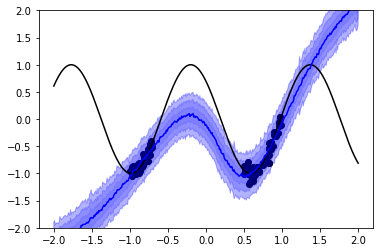

In [15]:
plt.scatter(x, y, color="black")
plt.plot(x_test, y_test, color="black")
plt.plot(x_test, m.detach(), color="blue")
for c in range(1, 4):
    plt.fill_between(x_test.squeeze(), (m - c * sd).squeeze(), (m + c * sd).squeeze(), alpha=c * 0.1, color="blue")
plt.ylim(-2, 2)

## Data division, FL


In [16]:
def partition_data(num, n_parties, beta_value):
  idx = torch.randperm(num).tolist()
  if len(beta_value)==1:
    beta = np.repeat(beta_value,n_parties)
  else:
    beta=beta_value
  proportions = np.random.dirichlet(beta)
  proportions = proportions / proportions.sum()
  proportions = (np.cumsum(proportions) * len(idx)).astype(int)[:-1]
  idx_batch = np.split(idx, proportions)
  return idx_batch

In [17]:
num_data= len(x)
n_parties = 3
beta_value=[80]
idx = partition_data(num_data, n_parties, beta_value)

In [36]:
elbos_append = []
bnns = []
param_dicts = []
for party in range(n_parties):
    # copy initial bnn, and local dataset
    bnn_i = copy.deepcopy(bnn0)
    dataset_loc = data.TensorDataset(x[idx[party]], y[idx[party]])
    loader_loc = data.DataLoader(dataset_loc, batch_size=len(x))

    pyro.clear_param_store()
    optim = pyro.optim.Adam({"lr": 1e-3})
    elbos_loc = []
    def callback(bnn_i, i, e):
        elbos_loc.append(e)
    with tyxe.poutine.local_reparameterization():
        bnn_i.fit(loader_loc, optim, 10000, callback)

    elbos_append.append(elbos_loc)
    bnns.append(bnn_i)
    param_dicts.append(copy.deepcopy(bnn_i.state_dict()))#pyro.get_param_store()))
    print('party:',party)

party: 0
party: 1
party: 2


In [ ]:
list(param_dicts[0].values())[0]

In [146]:
pyro.clear_param_store()

In [154]:
list(param_dicts[0].keys())

[]

## fusing utilities

In [37]:
# def fuse
# capping
def fuse_capping(rs, N_capping):
  sort_index = torch.argsort(rs,descending=True)
  index_cap = sort_index[0:N_capping]
  # rs_cap = rs[index_cap]
  # w_paras_cap = w_paras[index_cap]
  return index_cap #w_paras_cap, rs_cap, N_capping

def product_of_expert(meanCurrent_dict, scaleCurrent_mat_dict, W_vec):
    '''
    M: client number
    dimension: parameter w dimension
    param_w = [M, dimension,1]
    w_sigmas = [M, dimension, dimension]
    rs = [M]or[M,M]
    '''
    M = len(W_vec)
    dummy_mean = 0
    dummy_covar = 0
    for i in range(M):
        dummy_mean += torch.mm(torch.inverse(torch.diag(scaleCurrent_mat_dict[i].view(-1))**2),meanCurrent_dict[i].view(-1,1))*W_vec[i]
        dummy_covar +=  torch.inverse(torch.diag(scaleCurrent_mat_dict[i].view(-1))**2)*W_vec[i]

    covarCurrent_mat = torch.inverse(dummy_covar)
    meanCurrent_vec = torch.mm(covarCurrent_mat,dummy_mean)
    return meanCurrent_vec.view(meanCurrent_dict[i].shape), torch.diagonal(covarCurrent_mat**0.5,0).view(scaleCurrent_mat_dict[i].shape)

def product_fuse(param_w, param_w_scale, rs):
    
    rs = rs.view(1,-1)
    for i in range(len(param_w)):
      global_w_sigma = 1/torch.mm(rs[i], 1/param_w_scale[i]**2)
      global_w_mus = global_w_sigma * torch.mm(rs[i],param_w/param_w_scale[i]**2)
  
    return global_w_mus, global_w_sigma**0.5

def fusing(rs, w_mus_new, w_scale, fuse_method, **kwargs):
  if fuse_method == 'capping':
    index_cap = fuse_capping(rs, kwargs['N_capping'])
    rs_new = rs[index_cap]
    rs_new = rs_new/sum(rs_new)
    w_mus_new = w_mus_new[index_cap]
    w_scale_new = w_scale[index_cap]
    H = kwargs['N_capping']
  elif fuse_method=='pruning':
    pass
  elif fuse_method=='merge':
    w_mus_new, w_scale_new = product_of_expert(w_mus_new, w_scale, rs)
    rs_new = [1]
    H = 1
  return w_mus_new, w_scale_new, rs_new

# how to get the r, using the cross entroy as the 
def fun_r_w(r, losses):
    r_new = rs * torch.exp(-losses)
    return r_new

## Fuse all client's weight one iteration

In [39]:
# param_dicts : [[mean_layer0_party0,var_layer0_party0, mean_layer1_party0,var_layer1_party0,...],[mean_layer0_party1,var_layer0_party1, mean_layer1_party1,var_layer1_party1,...]]
# spilt the list into mean and variance, mean and variance,...
lst_num=len(param_dicts[0])
lst = [item for item in range(0,lst_num)]
idxs = [lst[i:i + 2] for i in range(0, len(lst), 2)]

# pyro.clear_param_store()
bnn_new = copy.deepcopy(bnn_i)
param_dict_new = bnn_new.state_dict() #pyro.get_param_store()

rs = torch.ones(n_parties)
N_capping = 1
fuse_method = 'merge' #'capping'
kwargs = {'N_capping':N_capping}

keys = list(param_dicts[0].keys())
for idx_w in idxs:
    param_weights_idx = []
    param_vars_idx = []
    for party in range(n_parties):
        param_dict = param_dicts[party]
        param_i_mean_var = [list(param_dict.values())[id] for id in idx_w]
        param_weights_idx.append(param_i_mean_var[0])
        param_vars_idx.append(param_i_mean_var[1])

    w_mus_new, w_scale_new, rs_new = fusing(rs, param_weights_idx, param_vars_idx, fuse_method, N_capping=N_capping)
    key_name=[keys[id] for id in idx_w]
    param_dict_new[key_name[0]] = w_mus_new
    param_dict_new[key_name[1]] = w_scale_new


In [21]:
list(param_dict_new.values())[3]

tensor([0.4539, 0.0297, 0.1550, 0.0138, 0.0435, 0.2466, 0.4958, 0.0186, 0.0110,
        0.4876, 0.0221, 0.0159, 0.0536, 0.4951, 0.0281, 0.0407, 0.0996, 0.4651,
        0.0129, 0.0733, 0.1038, 0.2247, 0.4950, 0.1540, 0.0261, 0.4947, 0.0559,
        0.3491, 0.3058, 0.0202, 0.3017, 0.0251, 0.0292, 0.0206, 0.0285, 0.4897,
        0.1775, 0.0262, 0.4784, 0.0101, 0.0314, 0.0364, 0.0403, 0.0275, 0.4896,
        0.0097, 0.4918, 0.4934, 0.0404, 0.0922], grad_fn=<AddBackward0>)

In [40]:
m, sd = bnn_new.predict(x_test, num_predictions=32)

(-2.0, 2.0)

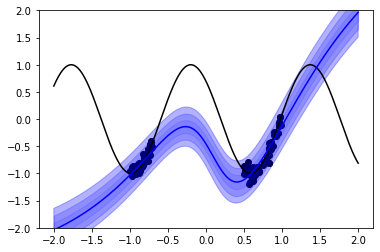

In [41]:
plt.scatter(x, y, color="black")
plt.plot(x_test, y_test, color="black")
plt.plot(x_test, m.detach(), color="blue")
for c in range(1, 4):
    plt.fill_between(x_test.squeeze(), (m - c * sd).squeeze(), (m + c * sd).squeeze(), alpha=c * 0.1, color="blue")
plt.ylim(-2, 2)

In [42]:
torch.square(m-y_test).sum()/len(y_test)

tensor(1.6803)

## GM-FL

In [ ]:
# get parameter
def get_param(bnn):
    param_dict = bnn.state_dict()
    param_weights_idx = torch.tensor([])
    param_vars_idx = torch.tensor([])

    lst_num=len(param_dict)
    lst = [item for item in range(0,lst_num)]
    idxs = [lst[i:i + 2] for i in range(0, len(lst), 2)]
    for idx_w in idxs:
        param_i_mean_var = [list(param_dict.values())[id] for id in idx_w]
        param_weights_idx = torch.cat(param_weights_idx, param_i_mean_var[0].view(-1))
        param_vars_idx = torch.cat(param_vars_idx, param_i_mean_var[1].view(-1))
    return param_weights_idx, param_vars_idx

def set_param(bnn, param_weights_idx, param_vars_idx):
    """
    Set_param2 is for the case:
    Given a vector of parameters, sets the parameters of self
    """
    i = 0
    j = 0
    param_dict = bnn.state_dict()
    lst_num=len(param_dict)
    lst = [item for item in range(0,lst_num)]
    idxs = [lst[i:i + 2] for i in range(0, len(lst), 2)]
    for idx_w in idxs:
        param_i_mean_var = [list(param_dict.values())[id] for id in idx_w]
        i_w = param_i_mean_var[0].nelement()
        j_b = param_i_mean_var[1].nelement()
        param_i_mean_var[0] = param_weights_idx[i:i+i_w].view(param_i_mean_var[0].size())
        param_i_mean_var[1] = param_vars_idx[j:j+j_b].view(param_i_mean_var[1].size())
        i += i_w
        j += j_b

    return bnn

In [ ]:
# prediction
def predict(model, test_x, test_y, samples):
    logsoftmax=torch.nn.LogSoftmax()
    log_softmax=0
    
    error, log_likelihood =model.evaluate(test_x,test_y,samples)
    # print(f'sample:{i}:{output}')
    # log_softmax += logsoftmax(output.data)
    # log_softmax_mean = log_softmax/samples
    _, predict_label = torch.max(log_likelihood, 1)
    # predict_label = model.predict(test_x,samples)

    return log_likelihood, predict_label

def FedBE_predict_clf(models, rs, x_test, y_test,samples=10):
    pos_r_mean = 0
    for i in range(len(rs)):
      log_likelihood, _ = predict(models[i], x_test, y_test, samples)
      pos_r = rs[i]*torch.exp(log_likelihood)
      pos_r_mean += pos_r
    _, predict_label = torch.max(pos_r_mean, 1)
    total = len(y_test)
    correct = (predict_label == y_test).sum().item()
    return correct/total

# regression
def predict_reg(model, test_x,test_y,samples):
    error, log_likelihood = model.evaluate(test_x,test_y,samples)
    return log_likelihood

def FedBE_predict_reg(models, rs, x_test, y_test,samples=10):
    pos_r = 0
    for i in range(len(rs)):
      log_likelihood = predict(models[i], x_test, y_test, samples)
      pos_r += rs[i]*torch.exp(log_likelihood)
      
    # _, predict_label = torch.max(pos_r_mean, 1)
    # error mse
    return torch.log(pos_r)

def train_h(bnn0, loader_loc, param_weight, param_var, rs, lr=0.001):
    bnn_h = copy.deepcopy(bnn0)
    bnn_h = set_param(bnn_h, param_weight, param_var)
    # train
    pyro.clear_param_store()
    optim = pyro.optim.Adam({"lr": lr})
    elbos_loc = []
    def callback(bnn_i, i, e):
        elbos_loc.append(e)
    with tyxe.poutine.local_reparameterization():
        bnn_h.fit(loader_loc, optim, 10000, callback)

    w_mus_new, w_scale_new = get_param(bnn_h)
    rs_new = fun_r_w(rs,bnn_h)
    return w_mus_new, w_scale_new, rs_new, elbos_loc

def fuse(w_mus, w_scales, rs, bnn0, x_test, y_test):
    w_mus_local, w_scales_local, rs_local = fusing(w_mus, w_scales, rs, bnn0)
    local_models = []
    for h_i in range(len(w_mus_local)):
        local_model = copy.deepcopy(bnn0)
        local_model = set_param(local_model, w_mus_local[h_i], w_scales_local[h_i])
        local_models.append(local_model)
    acc_m = FedBE_predict_clf(local_models, rs_local, x_test, y_test)
    
    print(f'test_acc_person for iteration {i}, parties{m}, {acc_m}')
    return w_mus_local, w_scales_local, rs_local, acc_m

In [ ]:
iterations = 10
fuse_personal = 1
fuse_globally = 0
test_acc_global = torch.zeros(iterations)
test_acc_person = torch.zeros([iterations,n_parties])

w_mu, w_scale = get_param(bnn0)

for iter in range(iterations):
    print('iter:', iter)
    w_mus_iter = torch.zeros((n_parties,H, w_mu.shape[0]))
    w_scales_iter = torch.zeros((n_parties,H, w_scale.shape[0]))
    rs_iter = torch.zeros((n_parties,H))
    # for personalized model
    # test_acc_person = torch.zeros(parties)
    
    w_mus_iter_new = []
    w_scales_iter_new = []
    rs_iter_new = []
    
    elbos_iter = []
    
    for party in range(n_parties):
        # copy initial bnn, and local dataset
        
        dataset_loc = data.TensorDataset(x[idx[party]], y[idx[party]])
        loader_loc = data.DataLoader(dataset_loc, batch_size=len(x))
        
        for h in range(H):
            if iter==0:
                w_mu_fuse, w_scale_fuse = get_param(bnn0)
                rs_fuse = [1]
                w_mus_fuse = [w_mu_fuse]
                w_scales_fuse = [w_scale_fuse]
            w_mus_iter[m,h], w_scales_iter[m,h], rs_iter[m,h], elbos_iter[m,h] = train_h(bnn0, loader_loc, w_mus_fuse[h], w_scales_fuse[h], rs_fuse[h], lr=0.001)
        
        rs_iter[m] = rs_iter[m] /sum(rs_iter[m])

        if fuse_personal:
            w_mus_local, w_scales_local, rs_local, acc_m = fuse(w_mus_iter[m], w_scales_iter[m], rs_iter[m], bnn0, x_test, y_test)
            print(f'test_acc_person for iteration {iter}, parties{m}, {acc_m}')

            if len(w_mus_local.shape)==1:
                w_mus_iter_new.append(w_mus_local)
                w_scales_iter_new.append(w_scales_local)
                rs_iter_new.append(rs_local)
            else:
                for k in range(len(w_mus_local)):
                    w_mus_iter_new.append(w_mus_local[k])
                    w_scales_iter_new.append(w_scales_local[k])
                    rs_iter_new.append(rs_local[k].data.numpy())
    
    if fuse_personal:
        w_mus_fuse = w_mus_iter_new
        w_scales_fuse = w_scales_iter_new
        rs_fuse = rs_iter_new
        H = len(w_mus_fuse)

    if fuse_globally:
        rs_new = rs_new/sum(rs_new)
        w_mus_fuse, w_scales_fuse, rs_fuse, acc_global = fuse(w_mus_iter.view(n_parties*H,-1), w_scales_iter.view(n_parties*H,-1), rs_iter.view(n_parties*H,-1), bnn0, x_test, y_test)
        print(f'iteration:{iter}, acc_global:{acc_global}')
        H = len(w_mus_fuse)
    

In [ ]:
# param_dicts : [[mean_layer0_party0,var_layer0_party0, mean_layer1_party0,var_layer1_party0,...],[mean_layer0_party1,var_layer0_party1, mean_layer1_party1,var_layer1_party1,...]]
# spilt the list into mean and variance, mean and variance,...
lst_num=len(param_dicts[0])
lst = [item for item in range(0,lst_num)]
idxs = [lst[i:i + 2] for i in range(0, len(lst), 2)]

rs = torch.ones(n_parties)
N_capping = 1
fuse_method = 'merge' #'capping'
kwargs = {'N_capping':N_capping}

def fuse_weight(bnn_i, param_dicts, rs, fuse_method, **kwargs):
    # pyro.clear_param_store()
    bnn_new = copy.deepcopy(bnn_i)
    param_dict_new = bnn_new.state_dict() #pyro.get_param_store()
    w_mus_news = []
    w_scale_news = []
    keys = list(param_dicts[0].keys())

    for idx_w in idxs:
        param_weights_idx = []
        param_vars_idx = []
        for party in range(n_parties):
            param_dict = param_dicts[party]
            param_i_mean_var = [list(param_dict.values())[id] for id in idx_w]
            param_weights_idx.append(param_i_mean_var[0])
            param_vars_idx.append(param_i_mean_var[1])

        w_mus_new, w_scale_new, rs_new = fusing(rs, param_weights_idx, param_vars_idx, fuse_method, N_capping=N_capping)

        # key_name=[keys[id] for id in idx_w]
        # param_dict_new[key_name[0]] = w_mus_new
        # param_dict_new[key_name[1]] = w_scale_new
    return bnn_new, param_dict_new, rs_new

In [37]:
# a = []
# for k in range(4):
#     b=[]
#     for j in range(3):
#         b.append(np.random.randn())
#     a.append(b)

# print(a)

[[0.24196227156603412, -1.913280244657798, -1.7249178325130328], [-0.5622875292409727, -1.0128311203344238, 0.3142473325952739], [-0.9080240755212109, -1.4123037013352915, 1.465648768921554], [-0.22577630048653566, 0.06752820468792384, -1.4247481862134568]]


# MCMC

In [14]:
pyro.clear_param_store()
net = nn.Sequential(nn.Linear(1, 50), nn.Tanh(), nn.Linear(50, 1))
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x), scale=0.1)
kernel = partial(pyro.infer.mcmc.HMC, step_size=1e-3, num_steps=50, target_accept_prob=0.7)
bnn = tyxe.bnn.MCMC_BNN(net, prior, obs_model, kernel)

In [15]:
bnn.fit(loader, 100000, warmup_steps=20000)

Sample: 100%|██████████| 120000/120000 [03:55, 510.20it/s, step size=2.52e-02, acc. prob=0.772]


In [16]:
m, sd = bnn.predict(x_test, num_predictions=32)

(-2.0, 2.0)

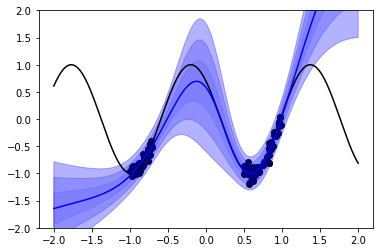

In [17]:
plt.scatter(x, y, color="black")
plt.plot(x_test, y_test, color="black")
plt.plot(x_test, m.detach(), color="blue")
for c in range(1, 4):
    plt.fill_between(x_test.squeeze(), (m - c * sd).squeeze(), (m + c * sd).squeeze(), alpha=c * 0.1, color="blue")
plt.ylim(-2, 2)

(-2.0, 2.0)

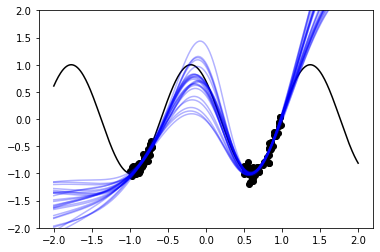

In [18]:
sampled_predictions = bnn.predict(x_test, num_predictions=25, aggregate=False)
plt.scatter(x, y, color="black")
plt.plot(x_test, y_test, color="black")
for yhat in sampled_predictions:
    plt.plot(x_test, yhat, color="blue", alpha=0.3)
plt.ylim(-2, 2)

##

In [19]:
net = nn.Sequential(nn.Linear(1, 50), nn.Tanh(), nn.Linear(50, 1))
optim = torch.optim.Adam(net.parameters(), 1e-4)
for _ in range(10000):
    optim.zero_grad()
    net(x).sub(y).pow(2).mean().backward()
    optim.step()

(-2.0, 2.0)

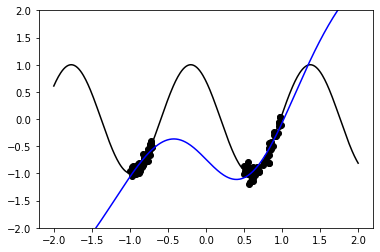

In [20]:
plt.scatter(x, y, color="black")
plt.plot(x_test, y_test, color="black")
plt.plot(x_test, net(x_test).detach(), color="blue")
plt.ylim(-2, 2)